In [1]:
import networkx as nx
import pybind11
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import shapely 
import os
import sys
from shapely import wkt
from shapely.geometry import Point
import random
from geopy.distance import geodesic
import re
os.chdir('/home/xuyuan/Desktop/2024 summer/real estate paper/oritignal cleaning/RealEstateBrokerage')

/home/xuyuan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


We need modification of the weight matrix using either the z-normalization or using the max-min normalization

In [2]:
data = pd.read_stata('template.dta')

In [3]:
codebook = {
    1: 'Beijing',
    2: 'Chengdu',
    3: 'Chongqing',
    4: 'Guangzhou',
    5: 'Hangzhou',
    6: 'Nanjing',
    7: 'Shanghai',
    8: 'Shenzhen',
    9: 'Tianjin',
    10: 'Wuhan'
}

data['city_id'] = data['city_id'].map(codebook)

In [4]:
map_data = data[(data['city_id'] == 'Beijing') & (data['year'] == 2019)]
map_data = gpd.GeoDataFrame(map_data, geometry = map_data.geometry.apply(wkt.loads))
df = pd.read_csv("classifying brokerages/processed/19_北京市.csv")
map_data['longitude'] = map_data['geometry'].apply(lambda point: point.x)
map_data['latitude'] = map_data['geometry'].apply(lambda point: point.y)

In [5]:
print(np.max(map_data['number']))
print(np.min(map_data['number']))

196
1


In [6]:
percentiles = np.arange(10, 91, 10)  # This will create an array from 10 to 90 inclusive
percentile_values = np.percentile(map_data['number'], percentiles).astype(float)  # Ensure they are float
np.set_printoptions(suppress=True)
# Create a DataFrame to display the results
percentile_values

array([ 1.,  2.,  3.,  4.,  6.,  9., 12., 18., 29.])

In [7]:
# the effect should be the number in the data
effects = map_data['number'].values
stores = df[['gpsx', 'gpsy']].values.tolist()
communities = map_data[['longitude', 'latitude']].values.tolist()


```
pip install pybind11

python3-config --cflags

pybind11-config --includes

cd /home/xuyuan/Desktop/2024\ summer/real\ estate\ paper/writing/RealEstateBrokerage/network_estimation

g++ -O3 -shared -std=c++11 -fPIC -I/usr/include/python3.10 -I/home/xuyuan/.local/lib/python3.10/site-packages/pybind11/include -o network_formulation.so network_formulation.cpp
```

In [8]:
os.chdir('/home/xuyuan/Desktop/2024 summer/real estate paper/writing/RealEstateBrokerage/network_estimation')
import network_formulation

In [9]:
within_distance_meters = 410.0 # this is what we find in the RD design
# Perform network formation
network, edges = network_formulation.network_formation(stores, communities, effects, within_distance_meters)

In [10]:
'''
# Create graph
G = nx.Graph()

# Add edges to the graph
for i, row in df_edges.iterrows():
    G.add_edge(row['store_id_1'], row['store_id_2'], weight=row['effect'])
# Find all connected components
components = list(nx.connected_components(G))
# Determine the size of each component
component_sizes = [len(component) for component in components]
# Find the largest component
largest_component = max(component_sizes)
# Calculate the average size of the components
average_size = sum(component_sizes) / len(component_sizes)
largest_component, average_size

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)
# Convert centralities to DataFrame for easier handling
centrality_df = pd.DataFrame({
    'degree_centrality': degree_centrality,
    'betweenness_centrality': betweenness_centrality,
    'closeness_centrality': closeness_centrality
})
# Calculate the mean network effect
mean_network_effect = df_edges['effect'].mean()
# Calculate the average network effect
average_network_effect = df_edges['effect'].mean()  # Mean and average are the same in this context
centrality_df.describe()
'''

"\n# Create graph\nG = nx.Graph()\n\n# Add edges to the graph\nfor i, row in df_edges.iterrows():\n    G.add_edge(row['store_id_1'], row['store_id_2'], weight=row['effect'])\n# Find all connected components\ncomponents = list(nx.connected_components(G))\n# Determine the size of each component\ncomponent_sizes = [len(component) for component in components]\n# Find the largest component\nlargest_component = max(component_sizes)\n# Calculate the average size of the components\naverage_size = sum(component_sizes) / len(component_sizes)\nlargest_component, average_size\n\n# Calculate degree centrality\ndegree_centrality = nx.degree_centrality(G)\n# Calculate betweenness centrality\nbetweenness_centrality = nx.betweenness_centrality(G)\n# Calculate closeness centrality\ncloseness_centrality = nx.closeness_centrality(G)\n# Convert centralities to DataFrame for easier handling\ncentrality_df = pd.DataFrame({\n    'degree_centrality': degree_centrality,\n    'betweenness_centrality': betweennes

In [11]:
df_edges = pd.DataFrame(edges, columns=["store_id_1", "store_id_2", "effect"])

In [12]:
df_network = []
for i, comm_effects in enumerate(network):
    for comm, effect in comm_effects:
        df_network.append((i, comm, effect))
df_network = pd.DataFrame(df_network, columns=["store_id", "community_id", "effect"])

In [13]:
def calculate_influential_effects(df_network, df_edges):
    # Create a graph
    G = nx.Graph()

    # Add nodes for stores and communities
    stores = df_network['store_id'].unique()
    communities = df_network['community_id'].unique()
    for store in stores:
        G.add_node(f'Store {store}', type='store')
    for community in communities:
        G.add_node(f'Community {community}', type='community')

    # Add edges based on df_network
    for _, row in df_network.iterrows():
        store_id = f'Store {row["store_id"]}'
        community_id = f'Community {row["community_id"]}'
        effect = row['effect']
        G.add_edge(store_id, community_id, weight=effect)
        # print(f"Edge added: {store_id} <-> {community_id}, Weight: {effect}")

    # Add edges based on df_edges
    for _, row in df_edges.iterrows():
        store_id_1 = f'Store {row["store_id_1"]}'
        store_id_2 = f'Store {row["store_id_2"]}'
        effect = row['effect']
        G.add_edge(store_id_1, store_id_2, weight=effect)
        # print(f"Edge added: {store_id_1} <-> {store_id_2}, Weight: {effect}")

    # Initialize community influence
    community_influence = {f'Community {i}.0': 0 for i in communities}
    # BFS to propagate influence
    # Function to propagate influence from a community through the network of stores
    def propagate_influence(community):
        # print(community)
        queue = []
        visited = set()

        # Initialize the queue with stores directly connected to the community
        for store_id in G.neighbors(community):
            if store_id.startswith('Store'):
                initial_effect = G[community][store_id]['weight']
                queue.append((store_id, initial_effect)) # (store_id, cumulative_effect)
                visited.add(store_id)
                # print(f"Initial: Community {community} -> Store {store_id}, Effect: {initial_effect}")


        # Perform BFS to propagate the influence
        while queue:
            current_store, current_effect = queue.pop(0)
            for neighbor in G.neighbors(current_store):
                if neighbor not in visited:
                    if neighbor.startswith('Store'):
                        # Calculate the propagated effect
                        edge_weight = G[current_store][neighbor]['weight']
                        new_effect = current_effect * edge_weight
                        queue.append((neighbor, new_effect))
                        visited.add(neighbor)
                        # print(f"Propagate: Store {current_store} -> Store {neighbor}, Effect: {new_effect}")
            # Update the influence for the initial community
            community_influence[community] += current_effect
            # print(f"Accumulate: Community {community}, Current Store {current_store}, Effect: {current_effect}")

    # Calculate the influence for each community
    for community in community_influence.keys():
        propagate_influence(community)

    return community_influence

In [14]:
# Calculate the average influential effect for each community
community_influence = calculate_influential_effects(df_network, df_edges)

In [15]:
community_influence_df = pd.DataFrame(list(community_influence.items()), columns=['community', 'influence'])
community_influence_df['community_id'] = community_influence_df['community'].str.extract(r'(\d+)').astype(int)

In [36]:
map_data.reset_index(drop = True, inplace = True)
map_data['community_id'] = map_data.index
merged_data = pd.merge(map_data, community_influence_df, on='community_id', how='left')

# print(len(community_influence_df['community_id'].unique()))
# print(merged_data['influence'].isnull().sum())

merged_data['influence'] = merged_data['influence'].fillna(0)

In [ ]:
merged_data['influence'].fillna(0, inplace = True)

In [39]:
merged_data[['number', 'influence']].head(20)

,number,influence
0,48,101.224320
1,4,9.493556
2,11,22.000000
3,1,0.000000
4,12,13.399739
5,1,0.000000
6,9,27.571560
7,12,0.000000
8,4,26.975395
9,21,0.000000


In [14]:
# now we need to convert the problem using cpp
G = nx.Graph()

In [15]:
for i, (lon, lat) in enumerate(stores):
    G.add_node(f'Store {i}', pos=(lon, lat), color='red', shape='o')

# Add nodes for communities
for i, (lon, lat) in enumerate(communities):
    G.add_node(f'Community {i}', pos=(lon, lat), color='blue', shape='s')

# Add edges based on df_network
for _, row in df_network.iterrows():
    store_id = row['store_id']
    community_id = row['community_id']
    effect = row['effect']
    G.add_edge(f'Store {store_id}', f'Community {community_id}', weight=effect, color='gray', style='dotted')

# Add edges based on df_edges
for _, row in df_edges.iterrows():
    store_id_1 = row['store_id_1']
    store_id_2 = row['store_id_2']
    effect = row['effect']
    G.add_edge(f'Store {store_id_1}', f'Store {store_id_2}', weight=effect, color='black', style='solid')

In [16]:
start_node = random.choice([f'Store {i}' for i in range(len(stores))])

In [17]:
start_node = 'Store 357' # Store 357

In [20]:
start_node

'Store 357'

In [18]:
bfs_edges = list(nx.bfs_edges(G, start_node, depth_limit=10))
bfs_nodes = set([start_node] + [v for u, v in bfs_edges])

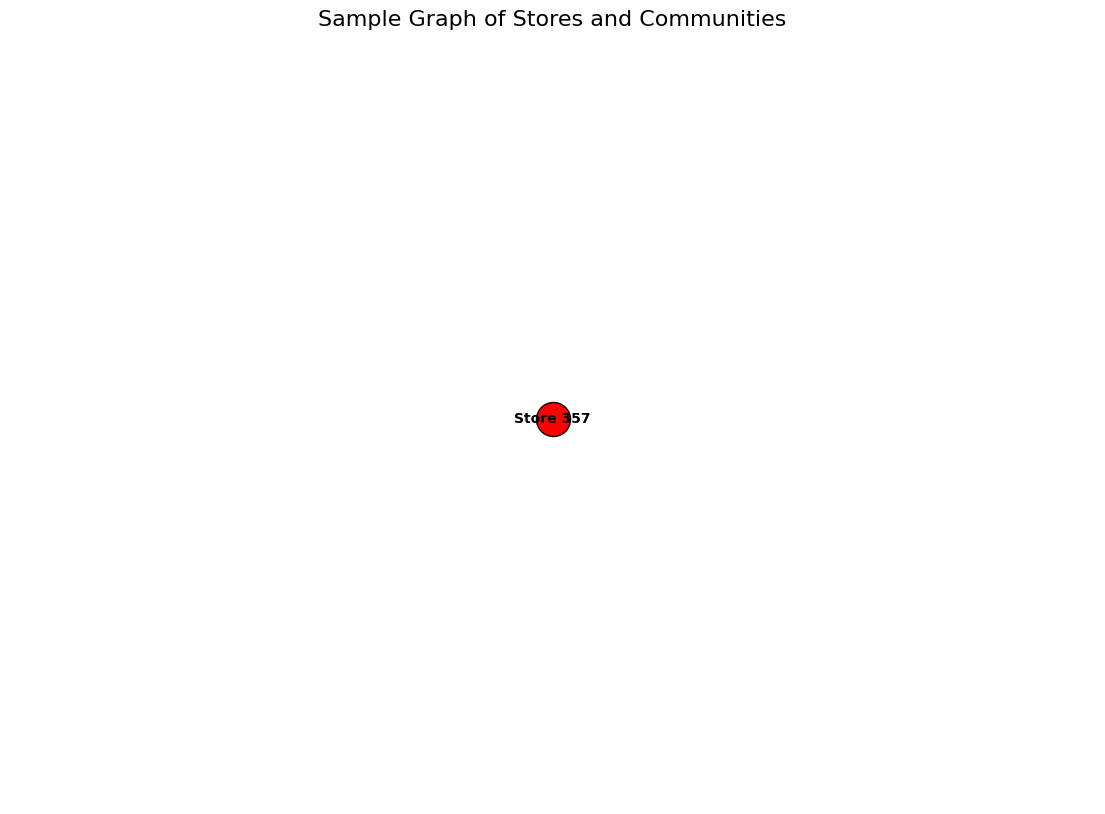

In [19]:
if start_node:
    # Perform BFS to get up to 10 neighbors
    bfs_edges = list(nx.bfs_edges(G, start_node, depth_limit=10))
    bfs_nodes = set([start_node] + [v for u, v in bfs_edges])

    # Subgraph for visualization
    H = G.subgraph(bfs_nodes)

    # Get positions for nodes
    pos = nx.get_node_attributes(G, 'pos')
    colors = nx.get_node_attributes(G, 'color')
    shapes = nx.get_node_attributes(G, 'shape')

    # Prepare the figure
    plt.figure(figsize=(14, 10))
    ax = plt.gca()

    # Draw nodes with specified colors and shapes
    for shape in set(shapes.values()):
        nx.draw_networkx_nodes(H, pos, nodelist=[node for node in H.nodes() if shapes[node] == shape],
                               node_color=[colors[node] for node in H.nodes() if shapes[node] == shape],
                               node_shape=shape, node_size=600, edgecolors='k')

    # Draw edges with different styles and widths based on effect
    for style in ['solid', 'dotted']:
        edges = [(u, v) for u, v, d in H.edges(data=True) if d['style'] == style]
        widths = [d['weight'] / 1000000 if 'weight' in d else 1 for u, v, d in H.edges(data=True) if d['style'] == style]
        colors = [d['color'] for u, v, d in H.edges(data=True) if d['style'] == style]
        nx.draw_networkx_edges(H, pos, edgelist=edges, width=widths, edge_color=colors, style=style)

    # Draw edge labels
    edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in H.edges(data=True) if 'weight' in d}
    nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_color='red', font_size=8)

    # Draw node labels
    nx.draw_networkx_labels(H, pos, font_size=10, font_weight='bold')

    # Title and display
    plt.title('Sample Graph of Stores and Communities', fontsize=16)
    plt.axis('off')
    plt.show()
else:
    print("No connected stores available for visualization.")

In [73]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
# eigenvector_centrality = nx.eigenvector_centrality(G)

# Print centralities
print("Degree Centrality:", degree_centrality)
print("Betweenness Centrality:", betweenness_centrality)
print("Closeness Centrality:", closeness_centrality)
# print("Eigenvector Centrality:", eigenvector_centrality)

Degree Centrality: {'Store 0': 0.000812787862367922, 'Store 1': 0.000948252506095909, 'Store 2': 0.001625575724735844, 'Store 3': 0.001625575724735844, 'Store 4': 0.000406393931183961, 'Store 5': 0.000812787862367922, 'Store 6': 0.001490111081007857, 'Store 7': 0.000541858574911948, 'Store 8': 0.000948252506095909, 'Store 9': 0.000677323218639935, 'Store 10': 0.000812787862367922, 'Store 11': 0.001219181793551883, 'Store 12': 0.000948252506095909, 'Store 13': 0.000812787862367922, 'Store 14': 0.000677323218639935, 'Store 15': 0.000812787862367922, 'Store 16': 0.000677323218639935, 'Store 17': 0.000406393931183961, 'Store 18': 0.000948252506095909, 'Store 19': 0.000541858574911948, 'Store 20': 0.000948252506095909, 'Store 21': 0.000948252506095909, 'Store 22': 0.000677323218639935, 'Store 23': 0.000948252506095909, 'Store 24': 0.000541858574911948, 'Store 25': 0.000541858574911948, 'Store 26': 0.000270929287455974, 'Store 27': 0.001083717149823896, 'Store 28': 0.001083717149823896, 'Sto

In [77]:
degree_centrality_values = list(degree_centrality.values())
betweenness_centrality_values = list(betweenness_centrality.values())
closeness_centrality_values = list(closeness_centrality.values())

avg_degree_centrality = sum(degree_centrality_values) / len(degree_centrality_values)
avg_betweenness_centrality = sum(betweenness_centrality_values) / len(betweenness_centrality_values)
avg_closeness_centrality = sum(closeness_centrality_values) / len(closeness_centrality_values)


print(f'Average Degree Centrality: {avg_degree_centrality}')
print(f'Average Betweenness Centrality: {avg_betweenness_centrality}')
print(f'Average Closeness Centrality: {avg_closeness_centrality}')

Average Degree Centrality: 0.00026663581236013964
Average Betweenness Centrality: 2.7845936135810875e-06
Average Closeness Centrality: 0.0007898806013121978
